In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from os import listdir
from os.path import join

from SCFInitialGuess.utilities import Molecule

def grep_molecule(input_file):
    import re
    
    with open(input_file) as f:
            
        molecule = re.search(r"\$molecule.*\$end", f.read(), re.DOTALL)
        if molecule is None:
            raise ValueError("No molecule found in " + f.name)
        else:
            molecule = molecule.group(0)

            # cut out geometries
            geometries = molecule.splitlines()[2:-1]

    # from geometries take the species and positions
    species, positions = [], []
    for line in geometries:
        splits = line.split()
        species.append(splits[0])
        positions.append(splits[1:])

    return species, positions

def fetch_molecules(folder):
    
    files = [file for file in listdir(folder) if ".inp" in file]
    
    for i, file in enumerate(files):
        
        print("Fetching: " + str(i + 1) + "/" + str(len(files)))

        mol = Molecule(*grep_molecule(join(folder, file)))
        
        mol.basis = "sto-3g"
        
        yield mol
        
        
molecules = list(fetch_molecules("butadien/data"))

Fetching: 1/200
Fetching: 2/200
Fetching: 3/200
Fetching: 4/200
Fetching: 5/200
Fetching: 6/200
Fetching: 7/200
Fetching: 8/200
Fetching: 9/200
Fetching: 10/200
Fetching: 11/200
Fetching: 12/200
Fetching: 13/200
Fetching: 14/200
Fetching: 15/200
Fetching: 16/200
Fetching: 17/200
Fetching: 18/200
Fetching: 19/200
Fetching: 20/200
Fetching: 21/200
Fetching: 22/200
Fetching: 23/200
Fetching: 24/200
Fetching: 25/200
Fetching: 26/200
Fetching: 27/200
Fetching: 28/200
Fetching: 29/200
Fetching: 30/200
Fetching: 31/200
Fetching: 32/200
Fetching: 33/200
Fetching: 34/200
Fetching: 35/200
Fetching: 36/200
Fetching: 37/200
Fetching: 38/200
Fetching: 39/200
Fetching: 40/200
Fetching: 41/200
Fetching: 42/200
Fetching: 43/200
Fetching: 44/200
Fetching: 45/200
Fetching: 46/200
Fetching: 47/200
Fetching: 48/200
Fetching: 49/200
Fetching: 50/200
Fetching: 51/200
Fetching: 52/200
Fetching: 53/200
Fetching: 54/200
Fetching: 55/200
Fetching: 56/200
Fetching: 57/200
Fetching: 58/200
Fetching: 59/200
Fetchi

In [6]:
from SCFInitialGuess.utilities.dataset import Dataset

S, P = np.load("butadien/dataset.npy")

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-20 17:36:50: Data set initialized. Mean value std: 0.008719936362488592


## Plot utuls

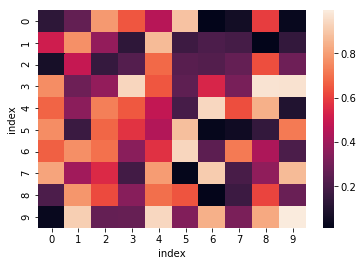

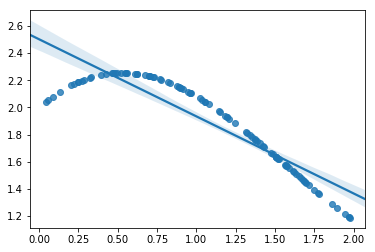

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cmap = plt.get_cmap('PuRd')# oder RdPu

def matrix_error(error, xlabel="index", ylabel="index", **kwargs):
    
    ax = sns.heatmap(error, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax
    

def prediction_scatter(actual, predicted):
    fig = plt.figure()
    sns.regplot(x=actual, y=predicted)
    
matrix_error(np.random.rand(10, 10))
x = np.random.rand(100) * 2
y = x + np.cos(x)*2
prediction_scatter(x, y)

plt.show()


## Training different costs

In [8]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-20 17:36:57: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 17:36:57: Setting up the training in the target graph ...
[-] 2018-03-20 17:36:57: network ...
[-] 2018-03-20 17:36:57: error function ...
[-] 2018-03-20 17:36:57: cost function ...
[-] 2018-03-20 17:37:07: training step
[-] 2018-03-20 17:37:07: Starting network training ...
[ ] 2018-03-20 17:37:07: Validation cost: 5.77736E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 17:37:09: Validation cost: 6.30403E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 17:37:10: Validation cost: 2.00180E-05. Diff to prev.: 4.3E-05
[ ] 2018-03-20 17:37:11: Validation cost: 1.23520E-05. Diff to prev.: 7.7E-06
[ ] 2018-03-20 17:37:12: Validation cost: 1.04087E-05. Diff to prev.: 1.9E-06
[ ] 2018-03-20 17:37:13: Validation cost: 9.71161E-06. Diff to prev.: 7.0E-07
[ ] 2018-03-20 17:37:14: Validation cost: 9.58987E-06. Diff to prev.: 1.2E-07
[ ] 2018-03-20 17:37:15: Validation cost: 1.42761E-05. Diff to prev.: 

### Enforce hermiticity

In [11]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.norm(reshaped - transposed, axis=(1,2))

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=1e-7)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-7
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-20 17:38:31: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 17:38:31: Setting up the training in the target graph ...
[-] 2018-03-20 17:38:31: network ...
[-] 2018-03-20 17:38:31: error function ...
[-] 2018-03-20 17:38:31: cost function ...
[-] 2018-03-20 17:38:31: training step
[-] 2018-03-20 17:38:31: Starting network training ...
[ ] 2018-03-20 17:38:31: Validation cost: 5.81020E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 17:38:32: Validation cost: 6.49219E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 17:38:33: Validation cost: 2.14948E-05. Diff to prev.: 4.3E-05
[ ] 2018-03-20 17:38:34: Validation cost: 1.69328E-05. Diff to prev.: 4.6E-06
[ ] 2018-03-20 17:38:36: Validation cost: 1.20887E-05. Diff to prev.: 4.8E-06
[ ] 2018-03-20 17:38:37: Validation cost: 1.05887E-05. Diff to prev.: 1.5E-06
[ ] 2018-03-20 17:38:38: Validation cost: 1.71992E-05. Diff to prev.: 6.6E-06
[ ] 2018-03-20 17:38:39: Validation cost: 1.62689E-05. Diff to prev.: 

TODO: maaß für erreichte symmetrie ausgeben!

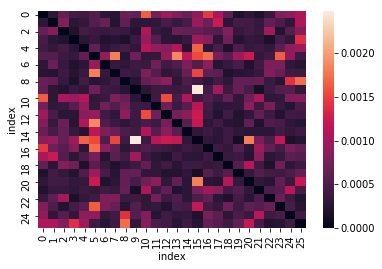

In [25]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_idem.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    matrix_error(sess_idem.run(diff_mean, {network_idem.input_tensor: dataset.testing[0]}))

plt.show()

### Enforce idempotency

In [14]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        squared = tf.matmul(reshaped, reshaped)
        
        return tf.norm(reshaped - squared, axis=(1,2))

    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-7)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=5e-8
)
graph_idem = trainer.graph

[-] 2018-03-20 17:41:07: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-20 17:41:07: Setting up the training in the target graph ...
[-] 2018-03-20 17:41:07: network ...
[-] 2018-03-20 17:41:07: error function ...
[-] 2018-03-20 17:41:07: cost function ...
[-] 2018-03-20 17:41:07: training step
[-] 2018-03-20 17:41:07: Starting network training ...
[ ] 2018-03-20 17:41:07: Validation cost: 5.76627E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-20 17:41:08: Validation cost: 6.71537E-05. Diff to prev.: 5.8E-02
[ ] 2018-03-20 17:41:09: Validation cost: 2.50121E-05. Diff to prev.: 4.2E-05
[ ] 2018-03-20 17:41:11: Validation cost: 1.80513E-05. Diff to prev.: 7.0E-06
[ ] 2018-03-20 17:41:12: Validation cost: 1.53028E-05. Diff to prev.: 2.7E-06
[ ] 2018-03-20 17:41:13: Validation cost: 1.07828E-05. Diff to prev.: 4.5E-06
[ ] 2018-03-20 17:41:14: Validation cost: 9.91330E-06. Diff to prev.: 8.7E-07
[ ] 2018-03-20 17:41:15: Validation cost: 1.04520E-05. Diff to prev.: 

TODO Ergebnis irgendwie darstellen!!! WIe idempotent ist die matrix jetzt?

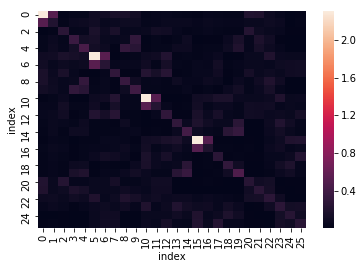

In [24]:
with graph_idem.as_default():
    reshaped = tf.reshape(network_idem.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    matrix_error(sess_idem.run(diff_mean, {network_idem.input_tensor: dataset.testing[0]}))

plt.show()
    
    

## Enforce interval

In [ ]:
"""
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IntervalPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IntervalPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_measure(self, output_tensor):
        
        output_tensor += (tf.sigmn(tf.abs(output_tensor)) + 1) * pow(output_tensor, 4)
        
        return tf.norm(reshaped - squared, axis=(1,2))

    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IntervalPenalty(coupling=1e-7)
)

trainer.setup()
network_int, sess_int = trainer.train(
    dataset,
    convergence_threshold=5e-8
)
graph_int = trainer.graph
"""

## Analysis

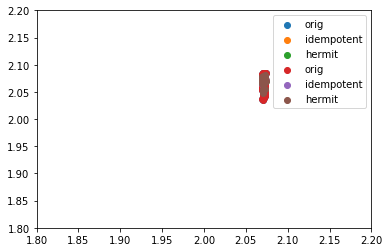

In [27]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

lower = 1.8
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [ ]:
from pyscf.scf import hf

dim = 26

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
        
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 1e-6
    
    
    iterations_molecule = []
    for guess in [P_orig, P_idem, P_sym, p_noise]:
        
        mf = hf.RHF(mol)
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

In [ ]:
print(np.mean(iterations,0))

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['orig', 'hermit', 'idempotent', 'noise']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()